In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms
import tag_genome_builder as tg_builder
from lib import tools
import config
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    

# input params

In [2]:
str_aggregated_path = r'C:\Users\shossein\Documents\personal\research\data\MA14KD_AGGREGATED.csv'
str_genome_scores = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\genome-scores.csv'
str_tag_ids = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\genome-tags.csv'
str_rating_path = r'C:\Users\shossein\Documents\personal\research\data\ml-20m\ratings.csv'
str_data_folder = r'C:\Users\shossein\Documents\personal\research\data'
minimum_no_of_frames = 10
number_of_tag_per_movie = 10

# Read inputs

In [3]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [4]:
# df_tag_ids.head()

In [5]:
df_genome = pd.read_csv(str_genome_scores)

In [6]:
df_ratings = pd.read_csv(str_rating_path)

In [7]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [8]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]

# Train test split

In [9]:
reload()
df_rating_train, df_rating_test, item_features_train, item_features_test = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

# Train recommender and predict on test

In [10]:
recommend = item_based.ItemBasedColabCos()
recommend.fit(df_rating_train, item_features_train)

In [11]:
test_users = df_rating_test[config.userId_col].unique()
recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=10)

In [12]:
df_rating_pred = pd.merge(df_rating_test, recommendations, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual'] = df_rating_pred[config.rating_col] - df_rating_pred[f'{config.rating_col}_predicted']

In [13]:
df_rating_pred['absolute residual'] = df_rating_pred['residual'].abs()

In [14]:
no_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted'].isnull().sum()
share_of_null_predictions = df_rating_pred[f'{config.rating_col}_predicted'].isnull().mean()

if no_of_null_predictions > 0:
    print(f'Warning: {no_of_null_predictions} ({np.round(share_of_null_predictions * 100 , 2)}%)'
          ' of ratings has no prediciton')

# Train the baseline recommender and predict on test

In [15]:
recommend_dummy = dummy_recommender.DummyAverageUser()
recommend_dummy.fit(df_rating_train, item_features_train)

In [17]:
recommendations_dummy = recommend_dummy.predict_on_list_of_users(test_users, 
                                                                 df_rating_test, 
                                                                 item_features_test, 
                                                                 n_jobs=10)
recommendations_dummy.rename(columns={f'{config.rating_col}_predicted': f'{config.rating_col}_predicted_average_user'},
                            inplace=True)

In [18]:
df_rating_pred = pd.merge(df_rating_pred, recommendations_dummy, on=[config.userId_col, config.movieId_col])

df_rating_pred['residual_average_user'] =\
    df_rating_pred[config.rating_col] - df_rating_pred[f'{config.rating_col}_predicted_average_user']

In [19]:
df_rating_pred['absolute residual_average_user'] = df_rating_pred['residual_average_user'].abs()

# looking at the performance

In [20]:
reload()
pd.concat([tools.performance_report(df_rating_pred, prediction_column_suffix=alg) for alg in ['', 'average_user']])

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
,3.528168,0.682277,0.888264,0.251764,0.285280,0.888161,-0.013571
average_user,3.528168,0.751801,0.964271,0.273306,0.157733,0.964683,-0.000722


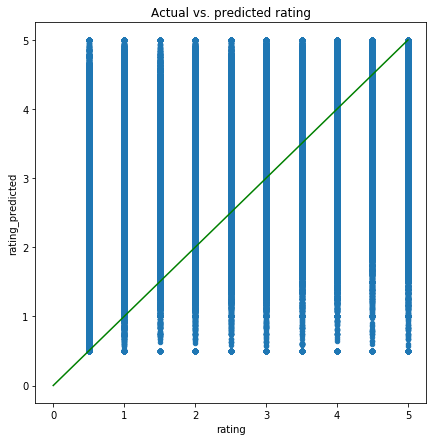

In [ ]:
reload()
tools.plot_actual_vs_prediction(df_rating_pred, prediction_column_suffix='')

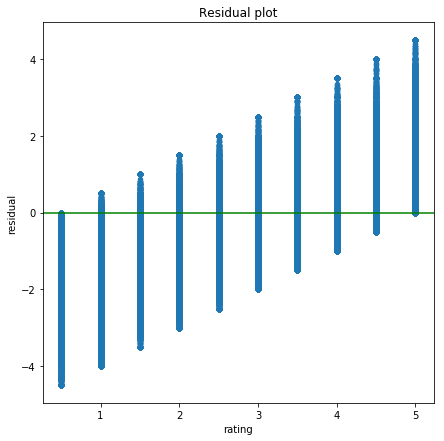

In [ ]:
reload()
tools.plot_residual_plot(df_rating_pred, prediction_column_suffix='')

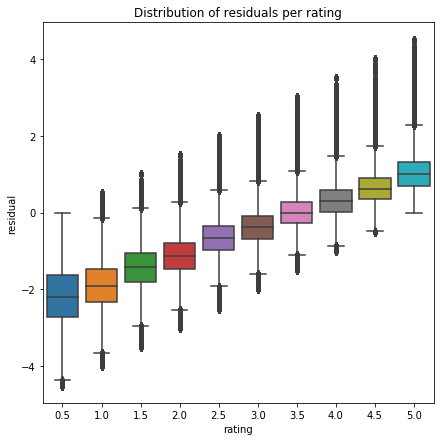

In [ ]:
reload()
tools.plot_residual_boxplot(df_rating_pred, prediction_column_suffix='')

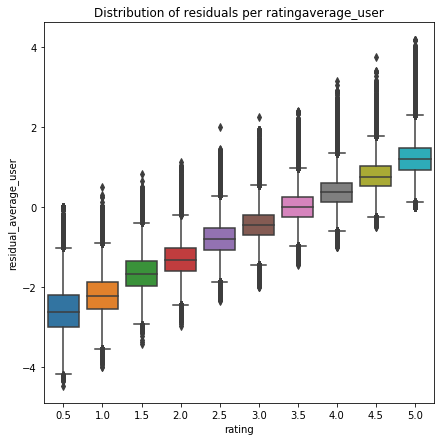

In [ ]:
tools.plot_residual_boxplot(df_rating_pred, prediction_column_suffix='average_user')

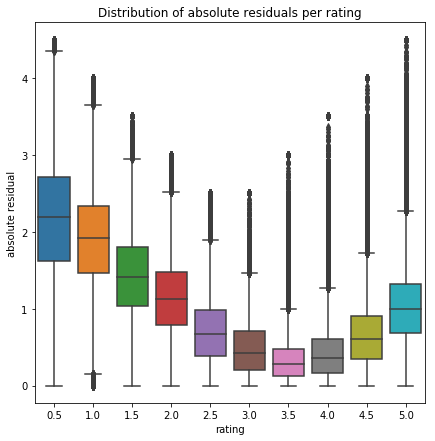

In [ ]:
reload()
tools.plot_absolute_residual_boxplot(df_rating_pred, prediction_column_suffix='')

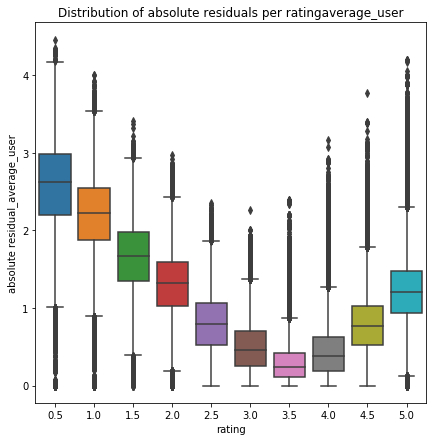

In [ ]:
tools.plot_absolute_residual_boxplot(df_rating_pred, prediction_column_suffix='average_user')

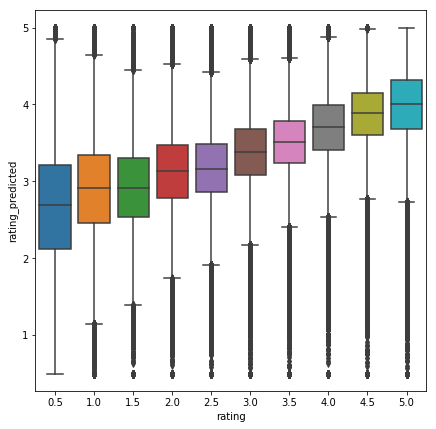

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(x=config.rating_col, y=f'{config.rating_col}_predicted', data=df_rating_pred)

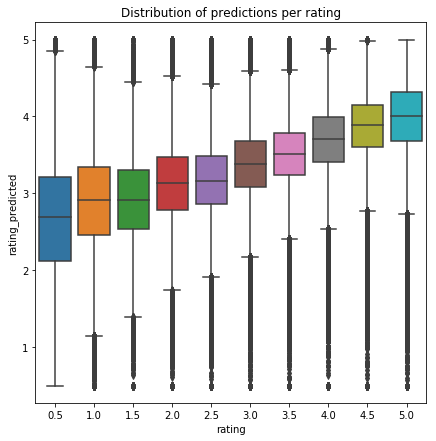

In [ ]:
reload()
tools.plot_actual_vs_predicted_boxplot(df_rating_pred, prediction_column_suffix='')

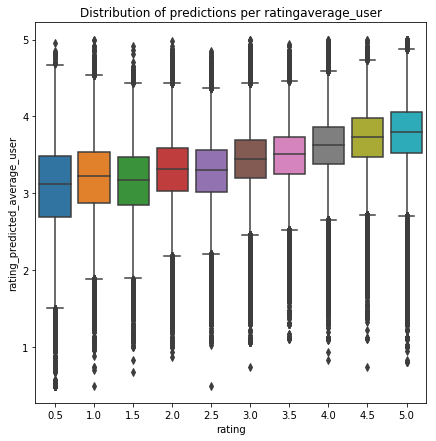

In [ ]:
reload()
tools.plot_actual_vs_predicted_boxplot(df_rating_pred, prediction_column_suffix='average_user')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


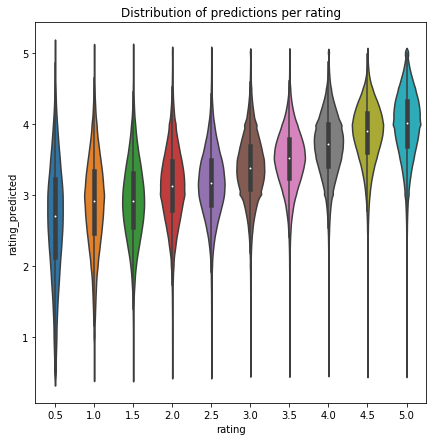

In [ ]:
reload()
tools.plot_actual_vs_predicted_violinplot(df_rating_pred, prediction_column_suffix='')

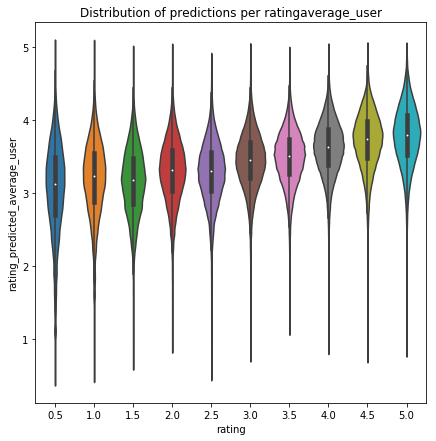

In [ ]:
reload()
tools.plot_actual_vs_predicted_violinplot(df_rating_pred, prediction_column_suffix='average_user')

# Save the current notebook in the results folder

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')